In [1]:
from typing import List
from logging import warning
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import io


In [2]:
IS_NOTEBOOK: bool = True  # @param {type: "boolean"}
TRANSLUCENCY_MAP_FILE_NAME: str = "translucency.png"  # @param {type: "string"}

PATH_PREFIX: str = (
    "https://raw.githubusercontent.com/YertleTurtleGit/photometric-stereo-mappings/main/test_dataset/"
    if IS_NOTEBOOK
    else "./../test_dataset/"
)

BACK_LIGHT_IMAGE_PATHS: List[str] = [
    PATH_PREFIX + str(index) + "b.png" for index in range(1, 8 + 1)
]
MASK_PATH = PATH_PREFIX + "output/opacity.png"

OUTPUT_PATH = None if IS_NOTEBOOK else PATH_PREFIX + "output/" + TRANSLUCENCY_MAP_FILE_NAME

In [3]:
def _read_image(
    image_path: str, color: bool = True, target_dtype: np.dtype = np.dtype("float64")
) -> np.ndarray:
    """Reads an image from URI and converts it to an array with specified bit depth.

    Args:
        image_path (str): The path to the image file.
        color (bool, optional): Read image as color image. Defaults to True.
        target_dtype (np.dtype, optional): The target bit depth. Defaults to np.dtype("float64").

    Returns:
        np.ndarray: The output array with shape (w,h,3) for color or (w,h) for grayscale images.
    """
    image = io.imread(image_path)
    image_dtype: np.dtype = image.dtype
    image = image.astype(target_dtype)

    if image_dtype == np.dtype("uint8"):
        image /= pow(2, 8) - 1
    elif image_dtype == np.dtype("uint16"):
        image /= pow(2, 16) - 1
    elif image_dtype == np.dtype("uint32"):
        image /= pow(2, 32) - 1

    if color:
        if len(image.shape) == 3:
            return image
        elif len(image.shape) == 2:
            return np.array([image, image, image])
        elif len(image.shape) == 4:
            return np.array([image[:, :, 0], image[:, :, 1], image[:, :, 2]])
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )
    else:
        if len(image.shape) == 2:
            return image
        elif len(image.shape) == 3 or len(image.shape) == 4:
            return (image[:, :, 0] + image[:, :, 1] + image[:, :, 2]) / 3
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )

    return image

In [4]:
def translucency_map(back_light_images_paths: List[str], output_path: str, mask_path: str = None):
    """Computes the translucency mapping given the back light images and saves it to the output path if supplied.
    Uses the exposure fusion algorithm.
    Mertens, Tom, Jan Kautz, and Frank Van Reeth. "Exposure fusion." 15th Pacific Conference on Computer Graphics and Applications (PG'07). IEEE, 2007.
    Args:
        back_light_images_paths (List[str]): Paths of back light images from top lighting.
        output_path (str): The path where the resulting albedo map is saved.
        mask_path (str, optional): Path of the mask that gets applied on the albedo map.
    """

    light_images = [
        np.clip(_read_image(image_path) * 255, 0, 255).astype("uint8")
        for image_path in back_light_images_paths
    ]

    merge_mertens = cv.createMergeMertens()
    translucency_map = merge_mertens.process(light_images)
    translucency_map = np.clip(translucency_map * 255, 0, 255).astype("uint8")

    if mask_path:
        mask_image = _read_image(mask_path, color=False)
        translucency_map[mask_image == 0] = (0, 0, 0)

    if output_path:
        translucency_map = cv.cvtColor(translucency_map, cv.COLOR_BGR2RGB)
        cv.imwrite(output_path, translucency_map)
    else:
        plt.imshow(translucency_map)


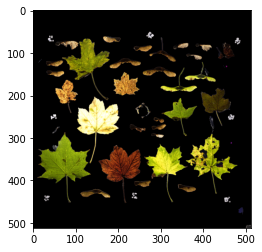

In [5]:
if __name__ == "__main__":
    translucency_map(BACK_LIGHT_IMAGE_PATHS, OUTPUT_PATH, MASK_PATH)
